In [14]:
from Functions import get_processed_data
from sklearn.decomposition import PCA
from Functions import make_pca_agg_fit,add_pca_and_graph, prep_data_splits,size_clusters,anaylsis
import torch 
import os
from transfer_learning import MyDataset,NeuralNet_sherpa_optimize
import torch.nn as nn
import torch.optim as optim
from ignite.engine import Engine,Events
import time 
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from Functions import Transfer_graphs,preformance_graph_and_prep_2nd_set,create_std_matrix,unpack_dic,create_dictionaries,make_distance_graph,distance_plots
import pandas as pd
from scipy.spatial import distance_matrix
import json
import dataframe_image as dfi

In [15]:

name="Toplology_6_run_resize"+".json"
with open(name, 'r') as f: 
  meta = json.load(f)
#needed from base file
epoch_conversions=  [561, 561, 561, 561, 561, 561] #specify by orginal file
#Gc Clusters
#[431, 1208, 2727, 3812, 3455, 1873]
#resize
#topology
#[561, 561, 561, 561]
#GC
#[431, 431, 431, 431, 431, 431]
#general number for 5 features (these manually need to be changed)
byte=268  
resolution=500
epochs=500
g_comp=6
#getting data files
processed=get_processed_data()
var=.9
#this code should not matter
interest=["H2@100 bar/243K (wt%)"]
interest2 = ['H2@100 bar/77K (wt%)']
#make PCA to run )
#Make PCA on data and generate 
pc1,pc2,color=make_pca_agg_fit(1,processed,var,g_comp,array_out=True,loud=False)
#get unprocessed data
data=get_processed_data(unprocessed=True)
pca_df=add_pca_and_graph(processed,pc1,pc2,color,graph=False)
#puts in old data needed, but can't be processed in PCA
pca_df[['MOF ID',interest[0],interest2[0],'topology']]=data[['MOF ID',interest[0],interest2[0],'topology']]

#removes some unneeded columns
abridge=pca_df[['MOF ID', 'void fraction', 'Vol. S.A.', 'Grav. S.A.','Pore diameter Limiting', 'Pore diameter Largest',interest[0],interest2[0],'topology', 'Pc1', 'Pc2', 'Cluster']]

In [16]:
# makes the map to change the process to topology conditions
map={
    
"Cluster 0":['tpt', 'crs', 'sodb', 'csq', 'bor', 'ctn', 'the', 'stp', 'rhrb', 'ssa'],

"Cluster 1":['srsb' ,'tbo' ,'spn'] ,

"Cluster 2":['soc' ,'pth' ,'pyr' 'iac', 'nbob', 'she'] ,

"Cluster 3":['bcs', 'ith', 'bcu', 'bct', 'fcu'] ,

"Cluster 4":['gar', 'flu', 'rht', 'nia', 'ftw', 'lvtb', 'ocu', 'scu', 'reo', 'pcu', 'acs'],

"Cluster 5":['pts', 'ssb', 'lcsb', 'pto', 'diab', 'qtz'] ,
}
large={}
for i in map:
    for g in map[i]:
        large[g]=i
        print(len(i))
abridge.groupby("topology").median()
abridge["topology_1"]=abridge["topology"].map(large)

9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9


<ipython-input-16-6ecd11670ac3>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abridge["topology_1"]=abridge["topology"].map(large)


In [17]:
%%capture
#surpressing output some of it is depreciated, plots are generated later with a df for clarity, this only serves to get df outputs now
# Below makes the colors
Cluster_colors=[
"#009E73",
"#E69F00",
"#56B4E9",
"#F0E442",
"#D55E00",
"#CC79A7"]
# Processes data for use
dic,dic2,std=create_dictionaries(g_comp)
dic=unpack_dic(dic,meta)
keys=[]
for i in dic:
    if not dic[i]:
        keys.append(i)
for i in keys:
    dic.pop(i)
# creates std matrix 
std=create_std_matrix(dic,std)
# more processing
dic2=preformance_graph_and_prep_2nd_set(Cluster_colors,dic,dic2,adjust=100,save=True)
keys=[]
for i in dic2:
    if not dic2[i]:
        keys.append(i)
for i in keys:
    dic2.pop(i)
# Generates data frames from data for future references
master=Transfer_graphs(dic2,resolution,epoch_conversions,Cluster_colors,byte,std,epochs,save=False)
hold=pd.DataFrame()
hold[['Pc1', 'Pc2',"topology_1"]]=abridge[['Pc1', 'Pc2',"topology_1"]]
display(hold.groupby("topology_1").median())
distances=distance_matrix(hold.groupby("topology_1").median(),hold.groupby("topology_1").median())
m1=make_distance_graph(dic,distances,Cluster_colors,"PC1 and PC2",save=False)
hold=pd.DataFrame()
hold[['Pc1',"topology_1"]]=abridge[['Pc1',"topology_1"]]
display(hold.groupby("topology_1").median())
distances=distance_matrix(hold.groupby("topology_1").median(),hold.groupby("topology_1").median())
m2=make_distance_graph(dic,distances,Cluster_colors,"PC1",save=False)
hold=pd.DataFrame()
hold[['Pc2',"topology_1"]]=abridge[['Pc2',"topology_1"]]
display(hold.groupby("topology_1").median())
distances=distance_matrix(hold.groupby("topology_1").median(),hold.groupby("topology_1").median())
m3=make_distance_graph(dic,distances,Cluster_colors,"PC2",save=False)

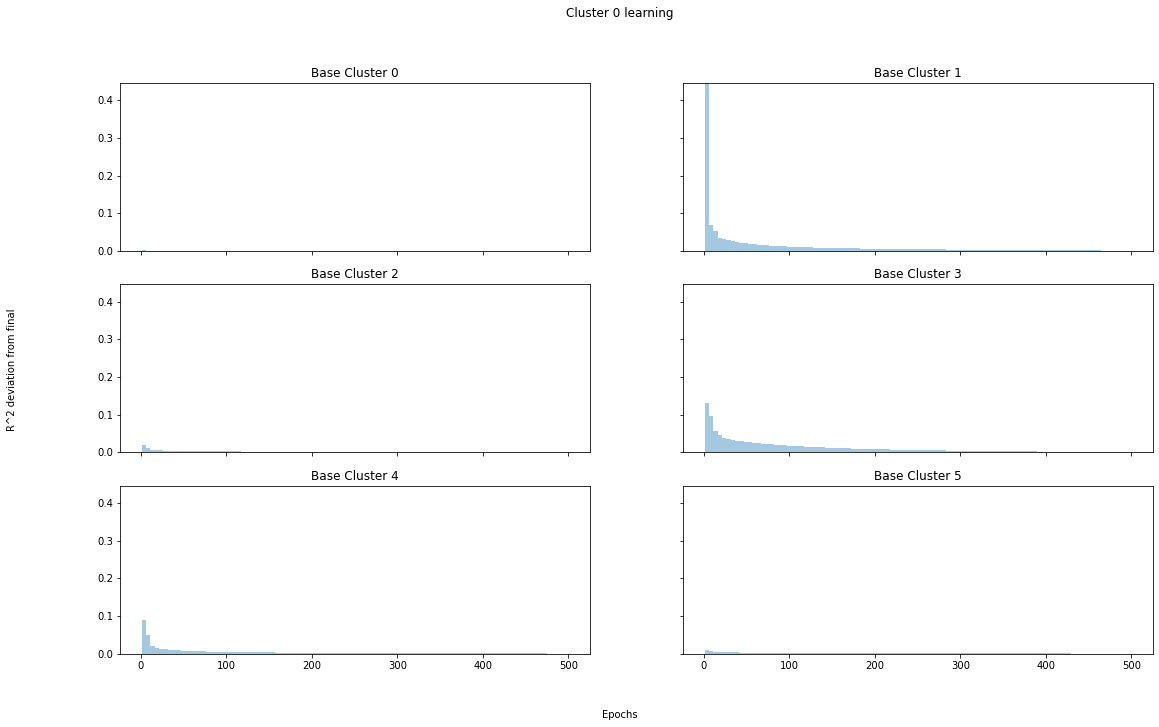

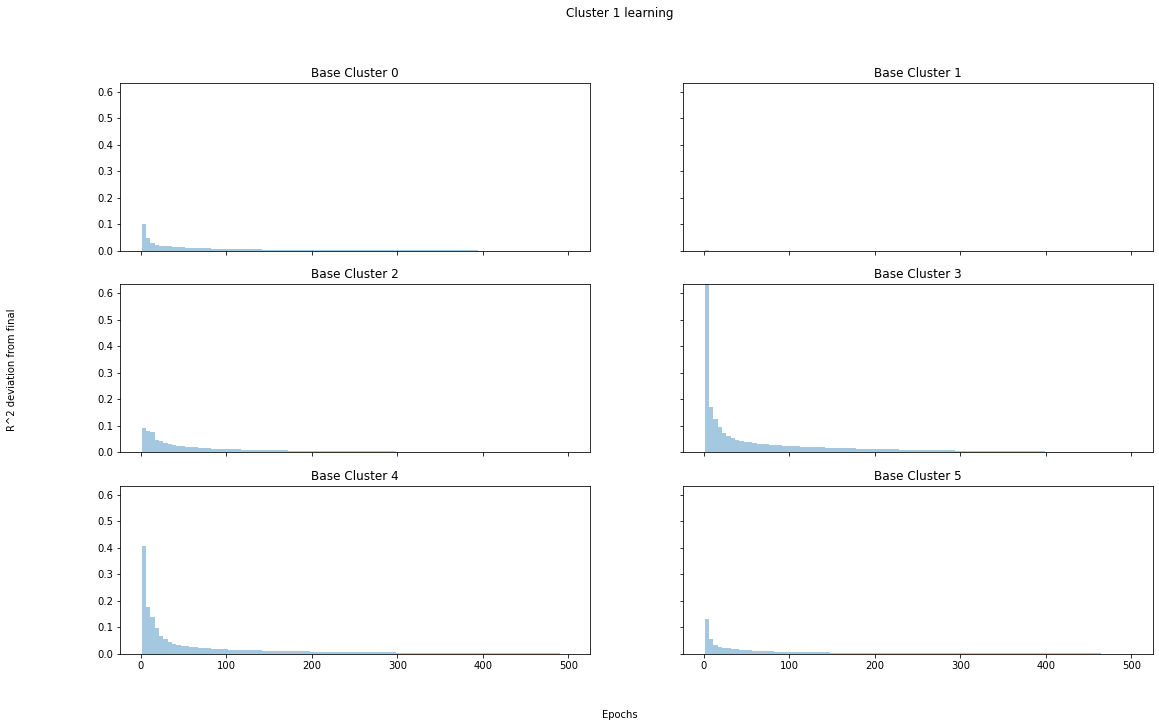

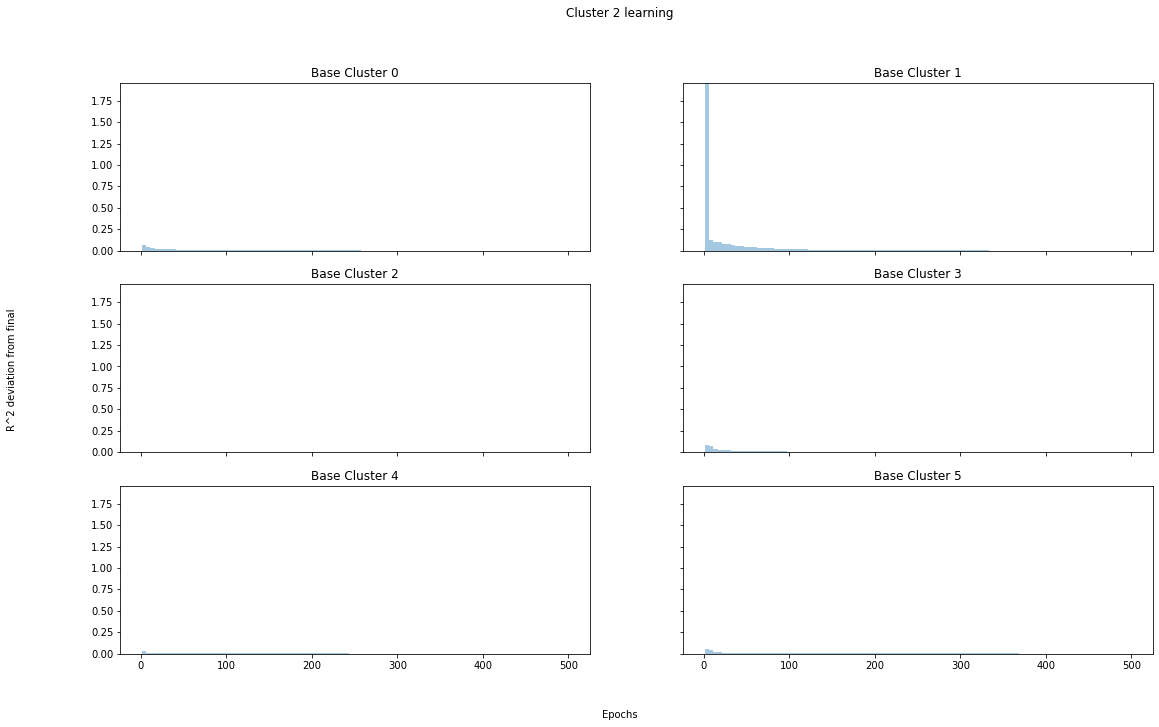

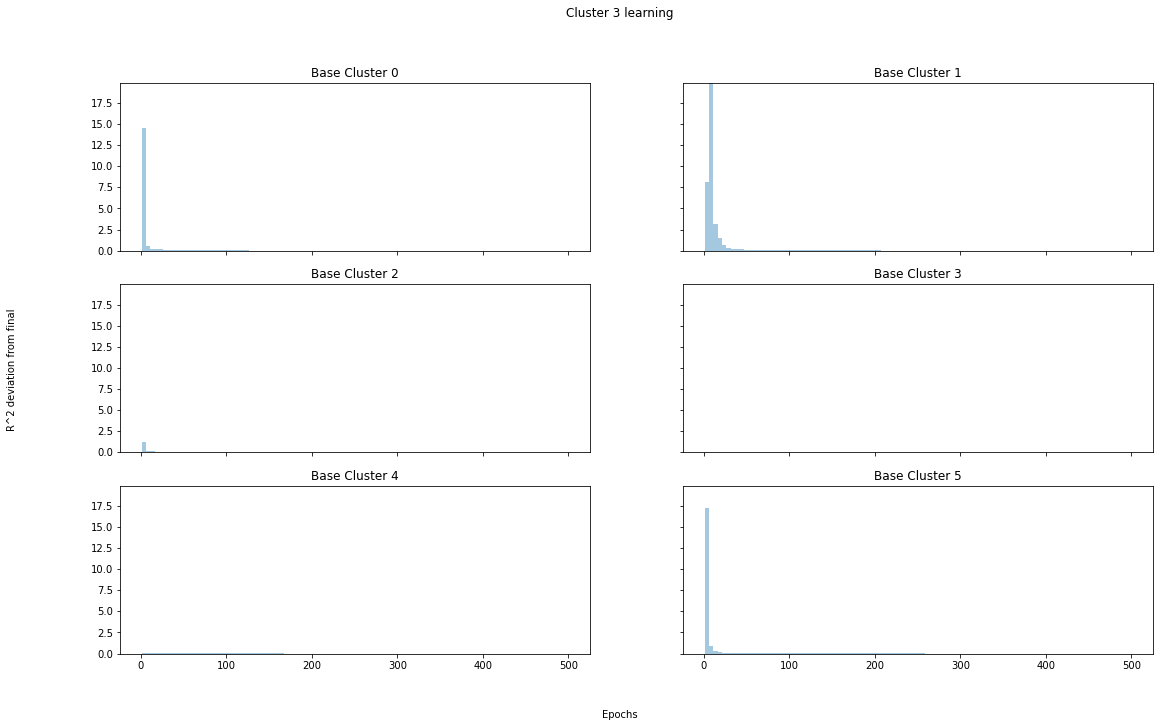

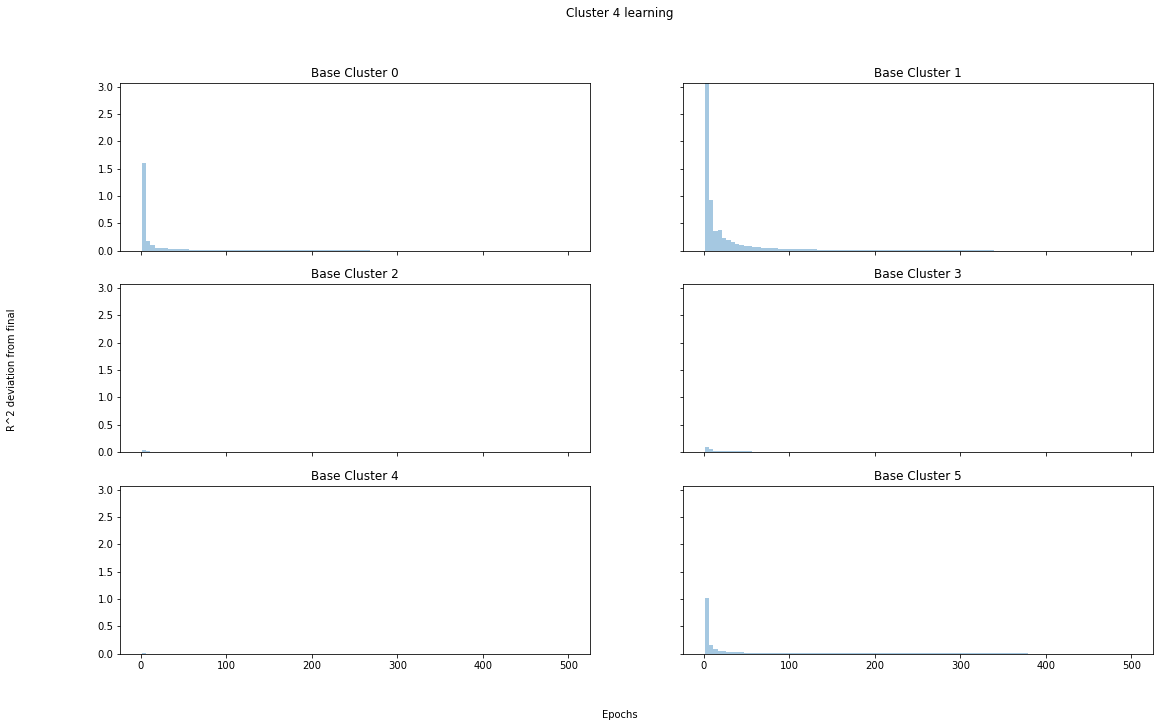

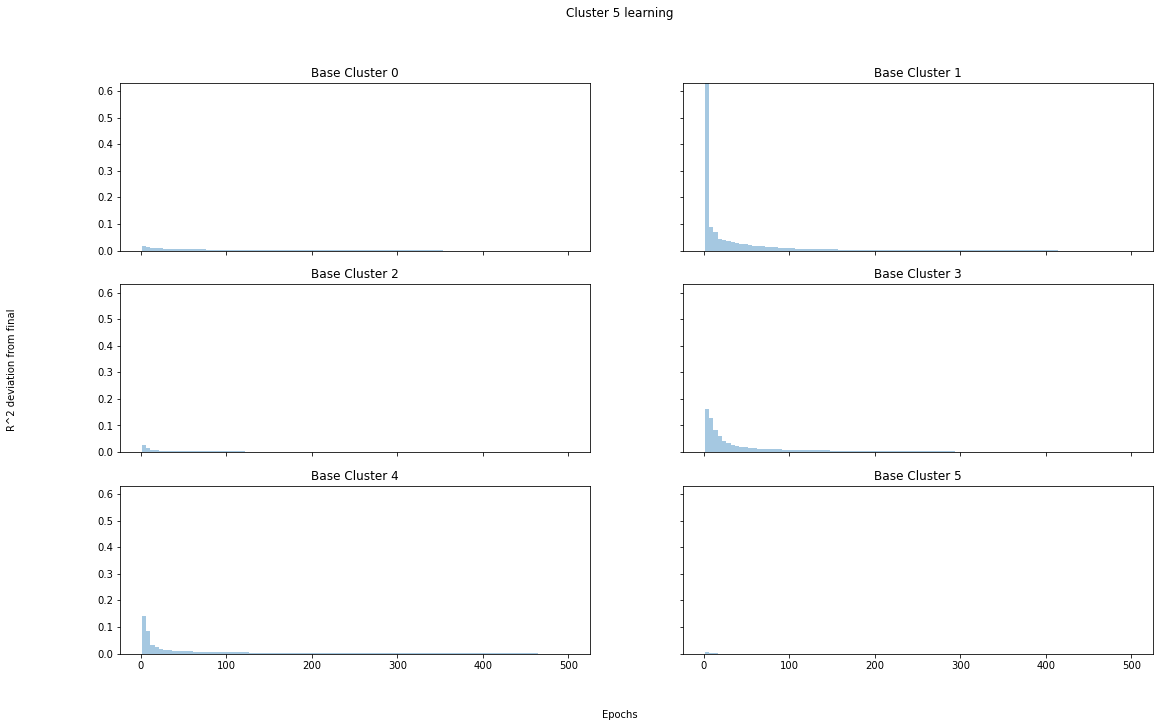

In [18]:
# Below proceses the learning curve and makes the figure comparision\
import numpy as np
base={}
std={}
for count,i in enumerate((meta[0])):
    i=meta[0][i]
    base[count]=(i)
for i in meta[1:]:
    for g in i:
        for count,z in enumerate(i[g]):
            base[int(g)][count]=np.array(base[int(g)][count])+np.array(z)
anaylsis(base,adjust=100)

In [19]:
# processes the data set for figure creation
main_df=pd.DataFrame()
sets=["set1","set2","set3"]
for count,i in enumerate(zip(m1,m2,m3)):
    a,b,c=i
    df=pd.DataFrame(m1[a]).T
    #display(df)
    df=df.reset_index(drop=False)
    df.columns=["Cluster","Distance",'Mean','Std']
    df["PC1 distance"]=pd.DataFrame(m2[b]).T[0]
    df["PC2 distance"]=pd.DataFrame(m3[c]).T[0]
    df[["Avg Worst (R^2 deviation)","Worst Std"]]=pd.DataFrame(master[(count,'set1')]).T
    df[["Avg Info. (MB to reach 95% Final)","Info Std"]]=pd.DataFrame(master[(count,'set2')]).T
    df[["Avg Learn (Net R^2 to reach 95% Final)","Learn Std"]]=pd.DataFrame(master[(count,'set3')]).T
    df["Base Cluster"]=count
    main_df=pd.concat([main_df,df],axis=0)
colors={}
for count,i in enumerate(Cluster_colors):
    colors[count]=i
real_df=main_df.sort_values(by="Distance").__deepcopy__()
real_df=real_df.replace("Over",0)
real_df=real_df.apply(abs)
real_df["color"]=real_df["Cluster"].map(colors)
groupped=real_df.groupby(["Base Cluster","Cluster"]).sum().replace(0,"N/A")
dfi.export(groupped, 'groupped.png')

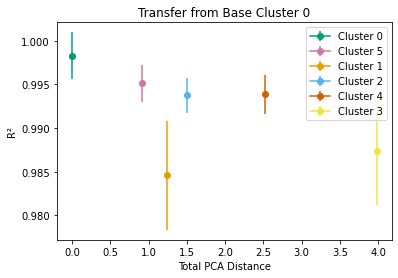

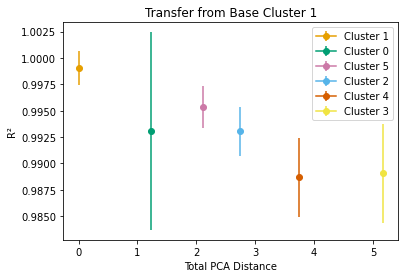

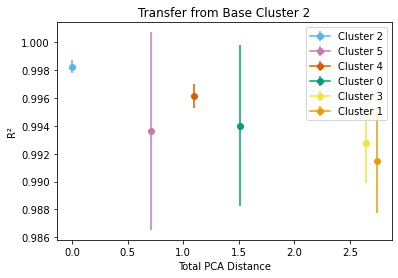

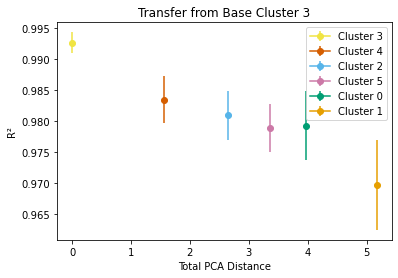

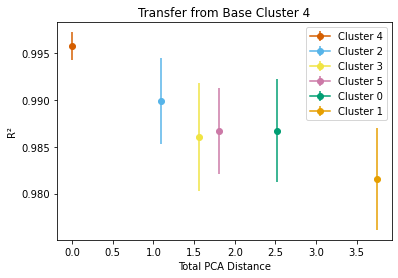

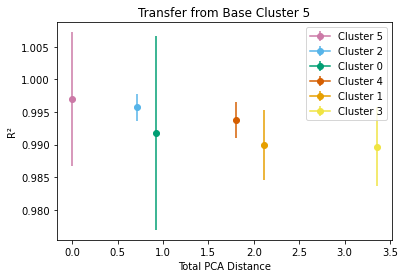

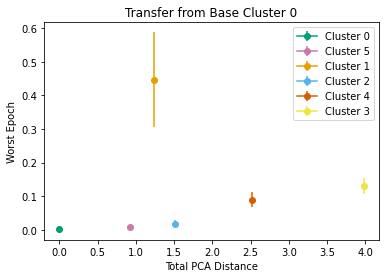

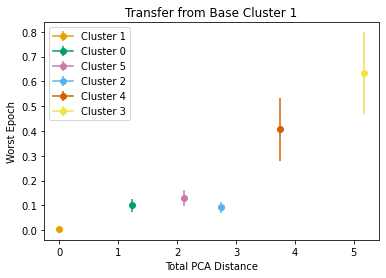

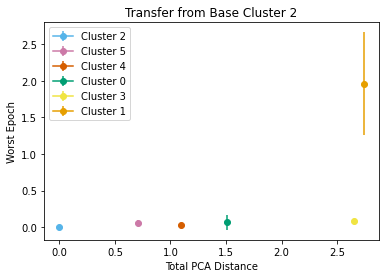

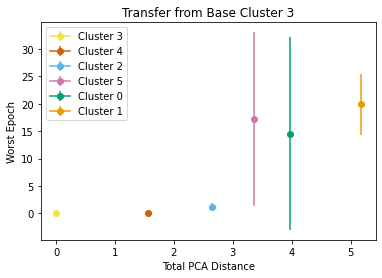

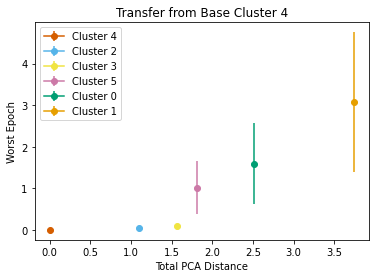

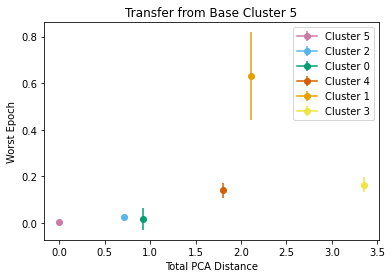

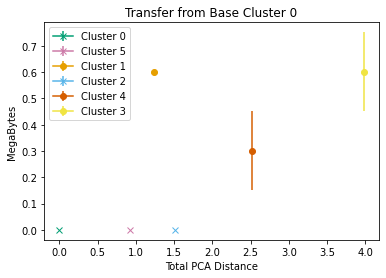

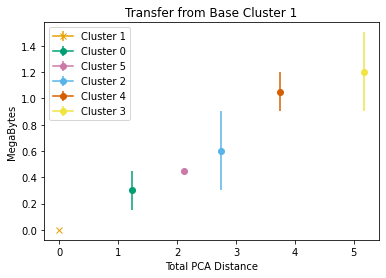

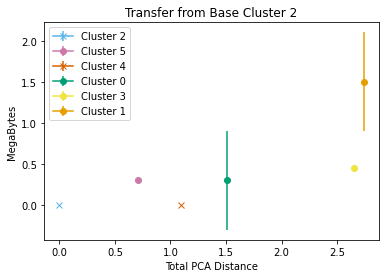

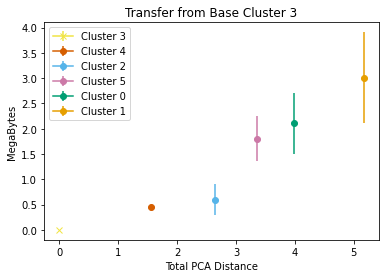

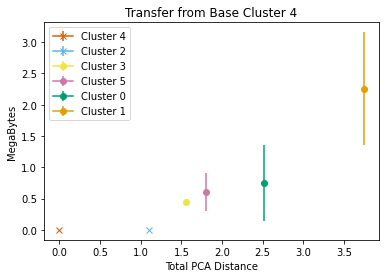

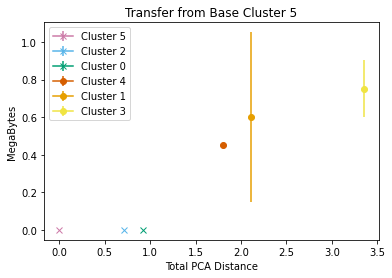

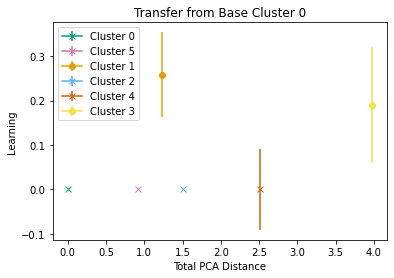

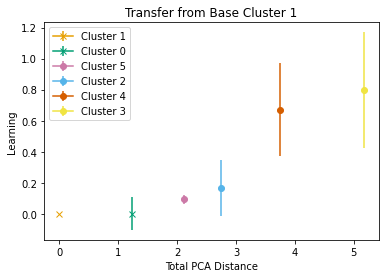

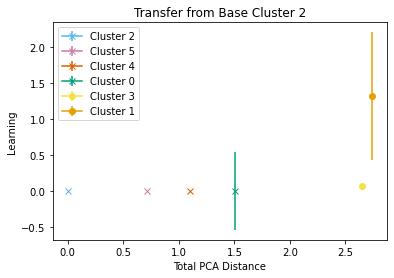

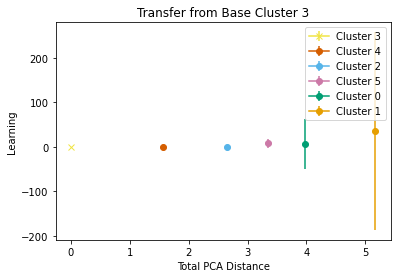

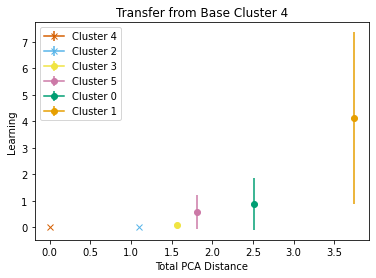

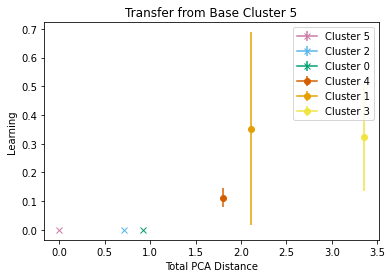

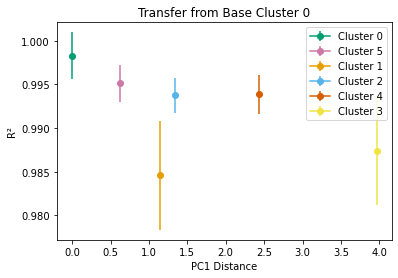

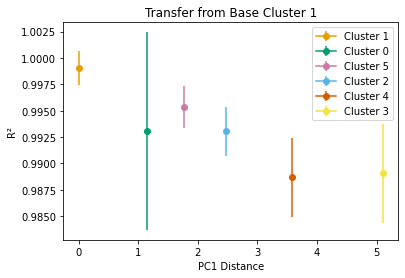

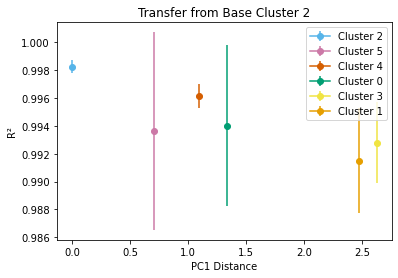

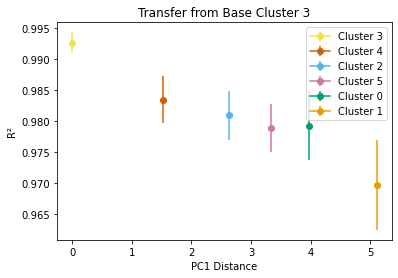

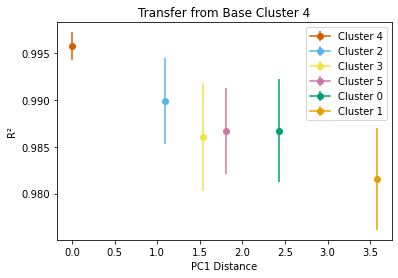

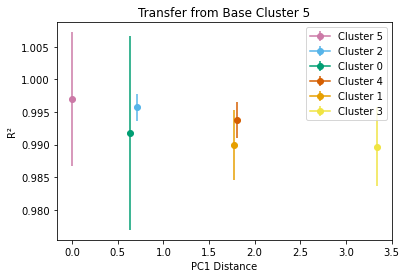

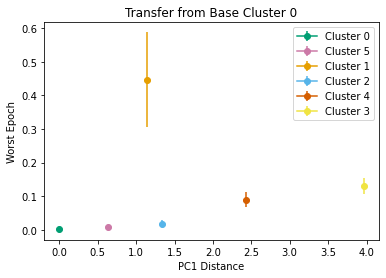

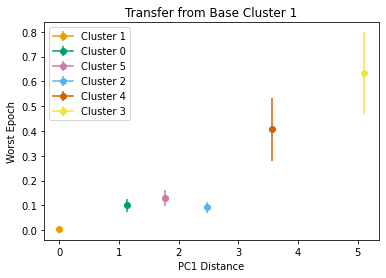

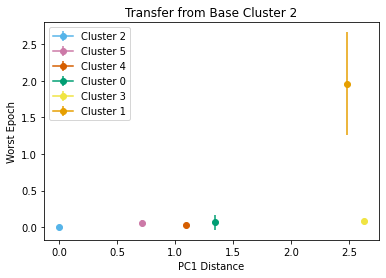

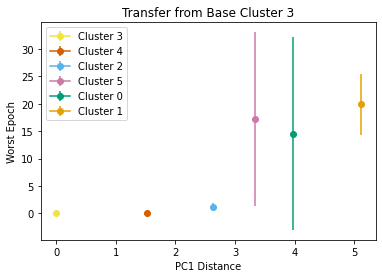

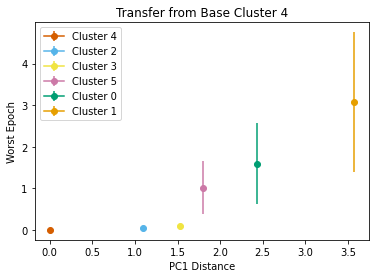

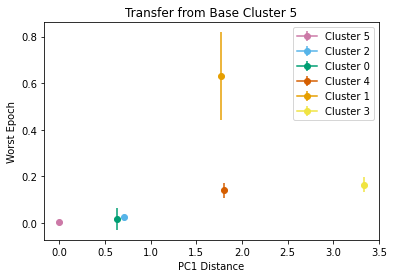

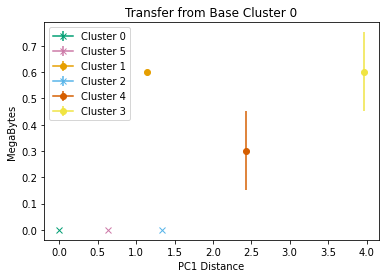

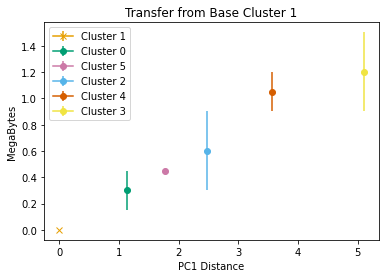

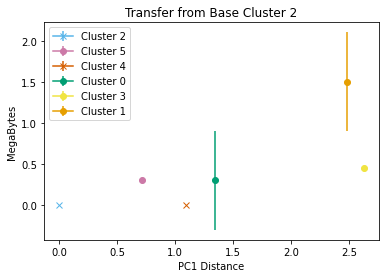

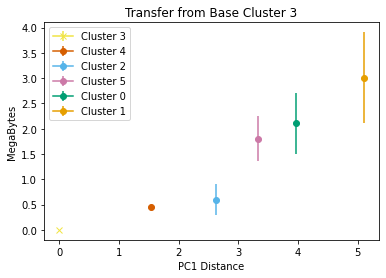

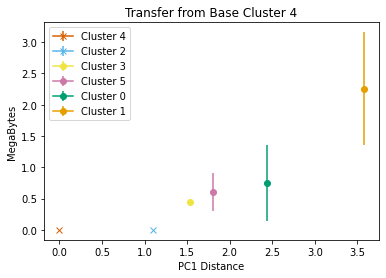

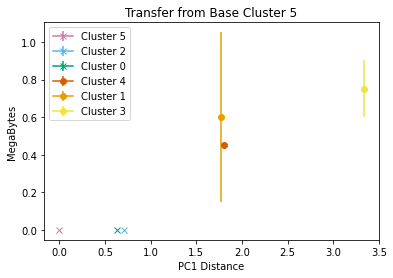

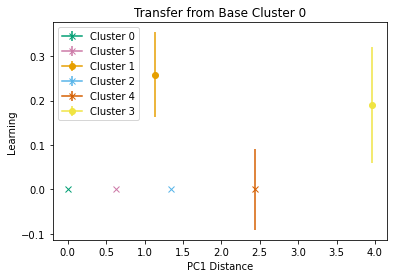

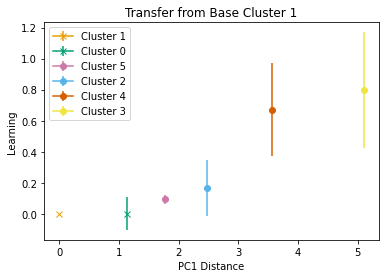

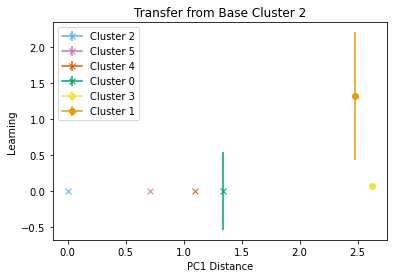

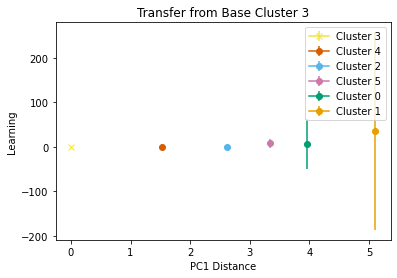

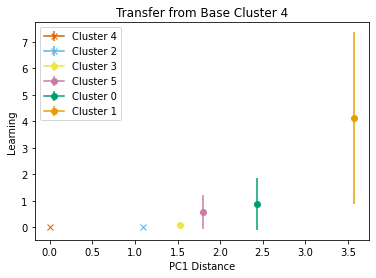

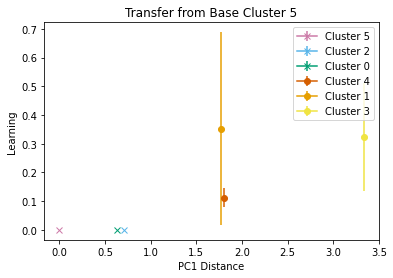

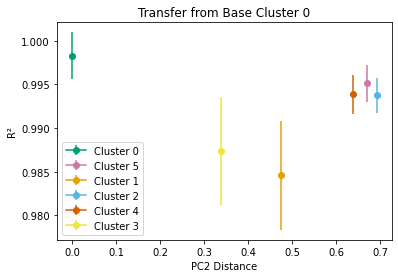

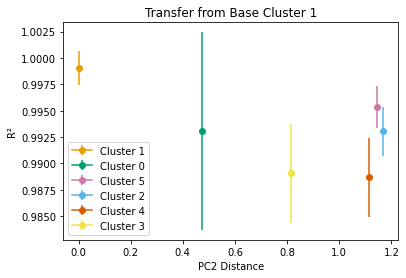

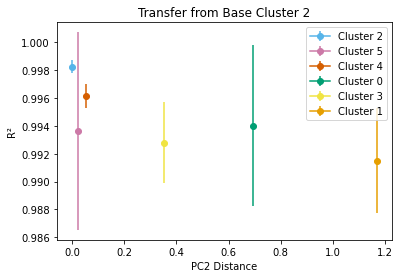

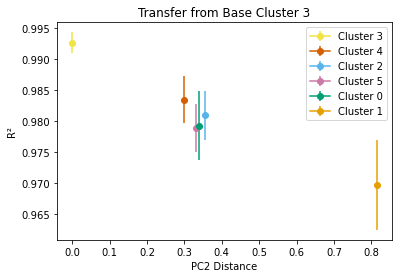

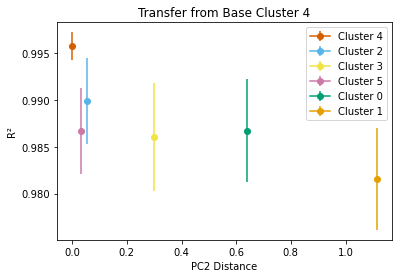

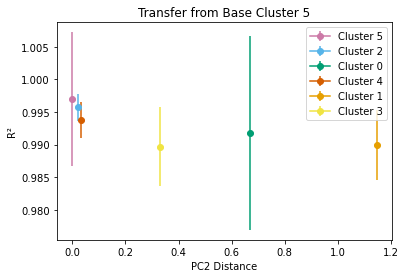

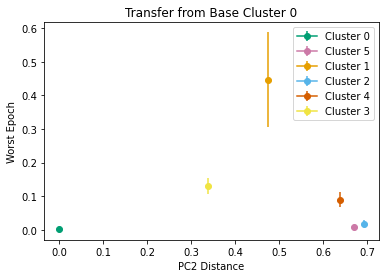

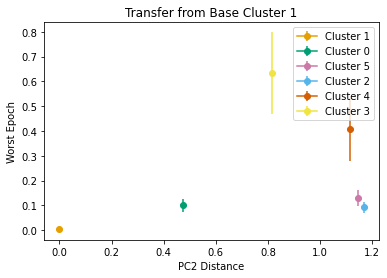

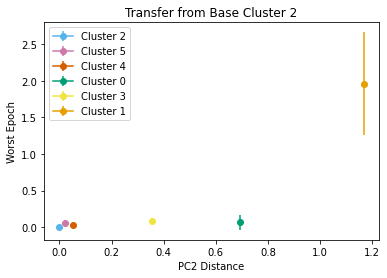

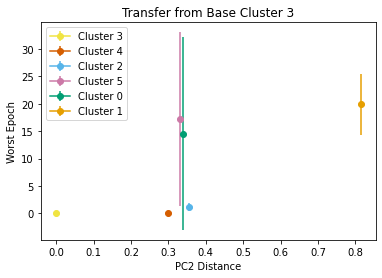

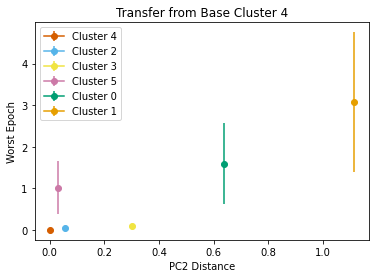

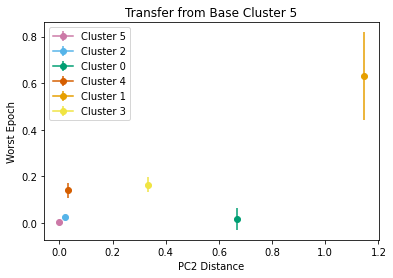

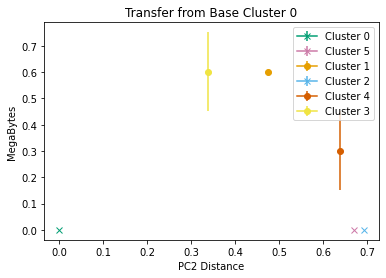

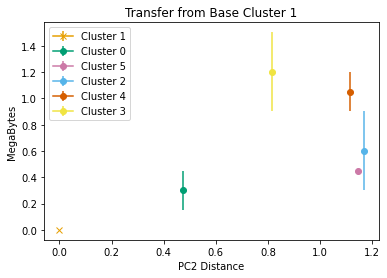

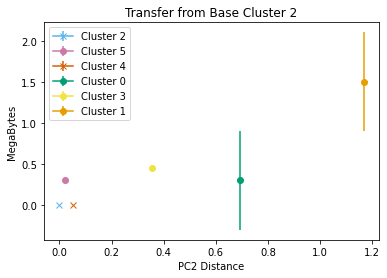

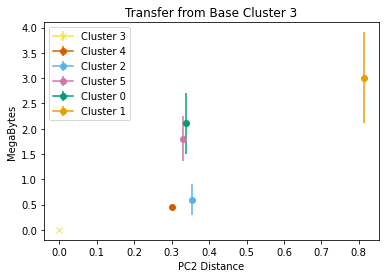

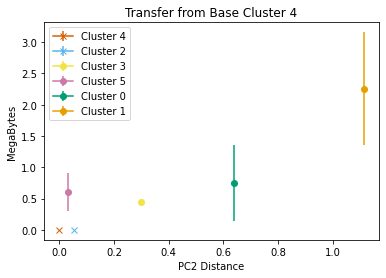

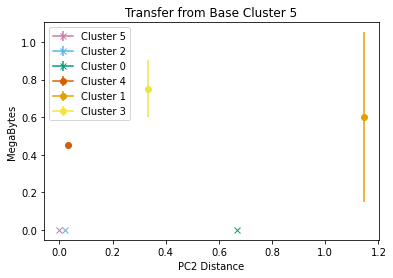

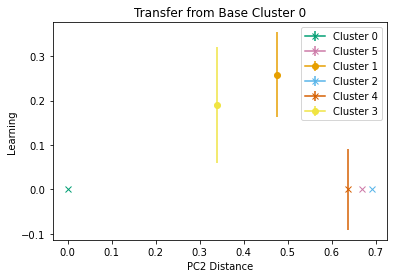

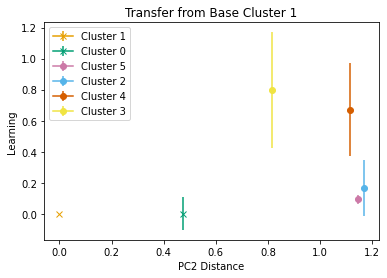

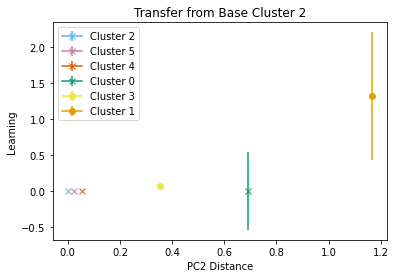

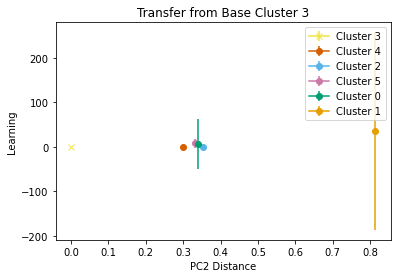

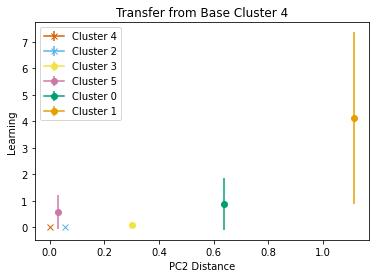

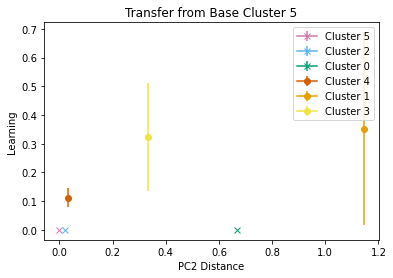

In [26]:
#Generates plots of data below
graphs={
0: ["Mean","Std"],
1: ["Avg Worst (R^2 deviation)","Worst Std"],
2: ["Avg Info. (MB to reach 95% Final)","Info Std"],
3: ["Avg Learn (Net R^2 to reach 95% Final)","Learn Std"],
}
x="Distance"
names=[u"R\u00b2","Worst Epoch","MegaBytes","Learning"]

def make_plot(df,x,y,error,base,xtitle,ytitle):
    for i in df.iterrows():
        i=i[1]
        if i[y] == 0:
            marker="x"
        else:
            marker='o'
        g=i["Cluster"]
        plt.errorbar(i[x],i[y],yerr=i[error],color=i["color"],marker=marker,label=f"Cluster {g}")
    plt.legend()
    plt.title(f"Transfer from Base Cluster {base}")
    plt.ylabel(ytitle) 
    plt.xlabel(xtitle)

for count,g in enumerate(graphs):
    y,error=graphs[g]
    for i in range(6):
        temp=real_df[real_df["Base Cluster"]==i]
        fig_label=f"{y}vs{x}_BC{i}.png"
        make_plot(temp,x,y,error,i,"Total PCA Distance",names[count])
        plt.savefig(fig_label,dpi=400)
        plt.show()
    
x="PC1 distance"
for count,g in enumerate(graphs):
    y,error=graphs[g]
    for i in range(6):
        temp=real_df[real_df["Base Cluster"]==i]
        fig_label=f"{y}vs{x}_BC{i}.png"
        make_plot(temp,x,y,error,i,"PC1 Distance",names[count])
        plt.savefig(fig_label,dpi=400)
        plt.show()

x="PC2 distance"
for count,g in enumerate(graphs):
    y,error=graphs[g]
    for i in range(6):
        temp=real_df[real_df["Base Cluster"]==i]
        fig_label=f"{y}vs{x}_BC{i}.png"
        make_plot(temp,x,y,error,i,"PC2 Distance",names[count])
        plt.savefig(fig_label,dpi=400)
        plt.show()

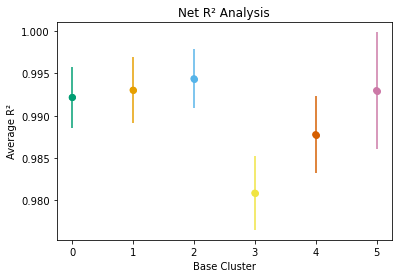

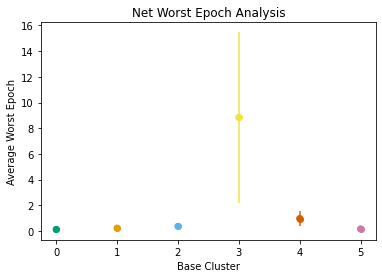

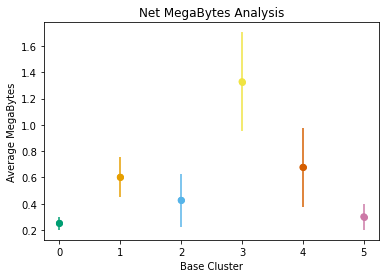

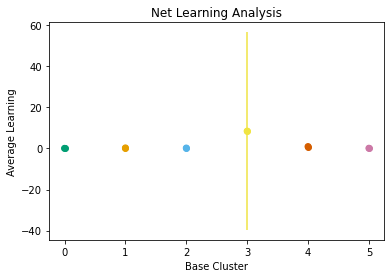

In [21]:
test=real_df.groupby("Base Cluster").mean()
test["Base Cluster"]=np.array(test.index)
test["Color"]=Cluster_colors
names=[u"R\u00b2","Worst Epoch","MegaBytes","Learning"]
for count,i in enumerate(graphs):
    a,b=graphs[i]
    #test.plot(kind="scatter",x="Base Cluster",y=a,yerr=b,ylabel=a,title=f"{a} vs Base Cluster",c=Cluster_colors)
    #plt.scatter(x=test["Base Cluster"],y=test[a],c=test["Color"])
    plt.scatter(x=test["Base Cluster"],y=test[a],c=test["Color"])
    for i in np.array(test.index):
        plt.errorbar(test["Base Cluster"][i],test[a][i],yerr=test[b][i],color=test["Color"][i],marker="o",label=f"Cluster {i}")
    #plt.errorbar(x=test["Base Cluster"],y=test[a],yerr=Cluster_colors)
    plt.title(f"Net {names[count]} Analysis")
    plt.xlabel("Base Cluster")
    plt.ylabel(f"Average {names[count]}")
    fig_label=f"META_{a}vsBC.png"
    plt.savefig(fig_label,dpi=400)
    plt.show()

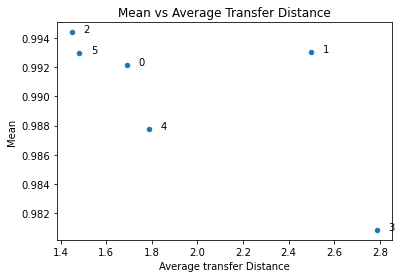

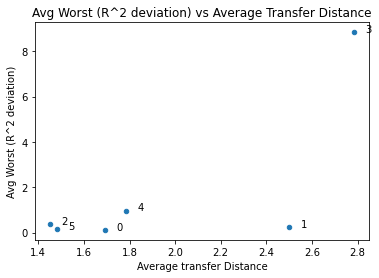

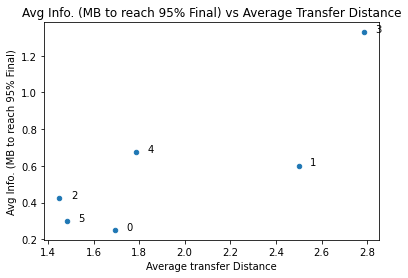

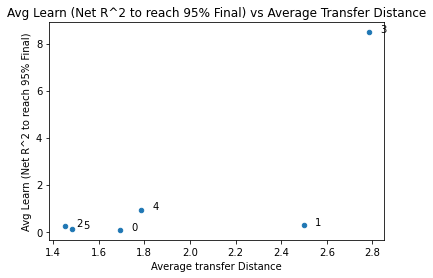

In [22]:
#Creates scatter plots for analysis (Nfp)

test['labels']=[0,1,2,3,4,5]
#if four
#test['labels']=[0,1,2,3]
distance_plots(test,"Mean")
plt.title("Mean vs Average Transfer Distance")
plt.xlabel("Average transfer Distance")
fig_label=f"META_scatter_mean.png"
plt.savefig(fig_label,dpi=400)
plt.show()

distance_plots(test,"Avg Worst (R^2 deviation)")
plt.title("Avg Worst (R^2 deviation) vs Average Transfer Distance")
plt.xlabel("Average transfer Distance")
fig_label=f"META_scatter_worst.png"
plt.savefig(fig_label,dpi=400)
plt.show()
distance_plots(test,"Avg Info. (MB to reach 95% Final)")
plt.title("Avg Info. (MB to reach 95% Final) vs Average Transfer Distance")
plt.xlabel("Average transfer Distance")
fig_label=f"META_scatter_info.png"
plt.savefig(fig_label,dpi=400)
plt.show()
distance_plots(test,"Avg Learn (Net R^2 to reach 95% Final)")
plt.title("Avg Learn (Net R^2 to reach 95% Final) vs Average Transfer Distance")
plt.xlabel("Average transfer Distance")
fig_label=f"META_scatter_learn.png"
plt.savefig(fig_label,dpi=400)
plt.show()

In [23]:
#Saves data for table
test=test.drop("Cluster",axis=1)
dfi.export(test, 'test.png')

In [24]:
#packages pngs
import os
folder=name[:-5]+"_New"
os.mkdir(folder)
path=os.getcwd()
for i in os.listdir(path):
    if (i[-3:]) == "png":
        os.rename(f"{path}/{i}",f"{path}/{folder}/{i}")
    else:
        pass

In [25]:
#Further formats pngs
path1=f"{path}/{folder}"
meta=path1+"/META"
pc1=path1+"/PC1"
pc2=path1+"/PC2"
rest=path1+"/regular"
tables=path1+"/Tables"
os.mkdir(meta)
os.mkdir(pc1)
os.mkdir(pc2)
os.mkdir(rest)
os.mkdir(tables)
for i in os.listdir(path1):
    if (i[-3:]) != "png":
        pass
    elif "META" in i:
        os.rename(f"{path1}/{i}",f"{meta}/{i}")
    elif "PC1" in i:
        os.rename(f"{path1}/{i}",f"{pc1}/{i}")
    elif "PC2" in i:
        os.rename(f"{path1}/{i}",f"{pc2}/{i}")
    elif "test" in i or "groupped" in i:
        os.rename(f"{path1}/{i}",f"{tables}/{i}")
    else:
        os.rename(f"{path1}/{i}",f"{rest}/{i}")
